In [59]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer

In [60]:
df = pd.read_csv(r'emails.csv')

In [61]:
print(len(df))

5728


In [62]:
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [63]:
df.describe()

,spam
count,5728.000000
mean,0.238827
std,0.426404
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [64]:
df['length']=df['text'].apply(len)
df.head()

,text,spam,length
0,Subject: naturally irresistible your corporate...,1,1484
1,Subject: the stock trading gunslinger fanny i...,1,598
2,Subject: unbelievable new homes made easy im ...,1,448
3,Subject: 4 color printing special request add...,1,500
4,"Subject: do not have money , get software cds ...",1,235


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

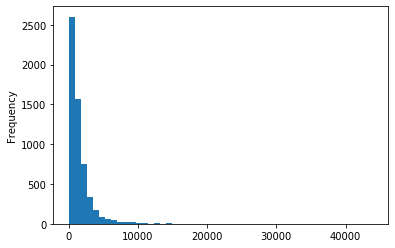

In [66]:
df['length'].plot(bins=50,kind='hist')

In [67]:
df.length.describe()

count     5728.000000
mean      1556.768680
std       2042.649812
min         13.000000
25%        508.750000
50%        979.000000
75%       1894.250000
max      43952.000000
Name: length, dtype: float64

In [68]:
df[df['length']==1222]['text'].iloc[0]

'Subject: ibuyit approvers  ah , these wonderful new systems ! i submitted an order on the " new " ibuyit  site and sent it for approval and it went to every manager in our group !  i called them and told them that only you were the approver and they do not  even have a user id set up for you . please fill out the below security document  and i will forward it on to them .  thanks !  shirley  - - - - - - - - - - - - - - - - - - - - - - forwarded by shirley crenshaw / hou / ect on 04 / 16 / 2001 03 : 26 pm - - - - - - - - - - - - - - - - - - - - - - - - - - -  from : michael loft / enron @ enronxgate on 04 / 16 / 2001 03 : 18 pm  to : shirley crenshaw / hou / ect @ ect  cc :  subject : ibuyit approvers  hi shirley  in processing your ibuyit approval change request , i discovered that vince kaminski has not been set up with a user id in the eprocurement system . please have him fill out the attached security form and send it to - - sap security @ enron . com  i have already selected the 

In [69]:
from bs4 import BeautifulSoup
from nltk import word_tokenize, WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def purify_text(message):
    soup = BeautifulSoup(message)
    text =  soup.get_text()
    text = text.replace("\n", " ").replace("/", "").replace("|", "").replace("http", "").replace(':', "").replace('\t', "").replace("Subject", "").replace('re', "").strip()
    tokens = word_tokenize(text)
    temp = [lemmatizer.lemmatize(word.lower()) for word in tokens]
    return ' '.join(temp)

In [70]:
df['text'] = df['text'].apply(purify_text)

In [71]:
df.head()

,text,spam,length
0,naturally irsistible your corporate identity l...,1,1484
1,the stock trading gunslinger fanny is merrill ...,1,598
2,unbelievable new home made easy im wanting to ...,1,448
3,4 color printing special quest additional info...,1,500
4,"do not have money , get softwa cd from he ! so...",1,235


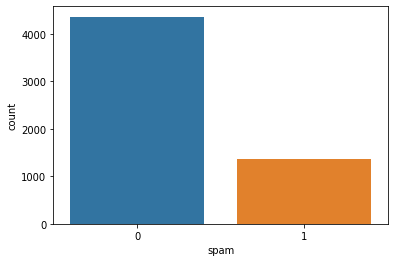

In [72]:
sns.countplot(df['spam'])

In [73]:
df[df['length']>3500]['spam'].value_counts()

0    397
1     87
Name: spam, dtype: int64

In [74]:
for index in df[df['length']>3500].index.tolist():
    df.drop(index=index, axis=1, inplace=True)

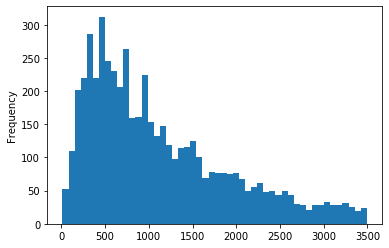

In [75]:
df['length'].plot(bins=50,kind='hist')

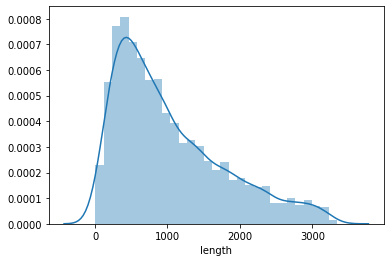

In [76]:
df['length'] = df['text'].apply(len)
sns.distplot(df['length'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4765320d0>,
      dtype=object)

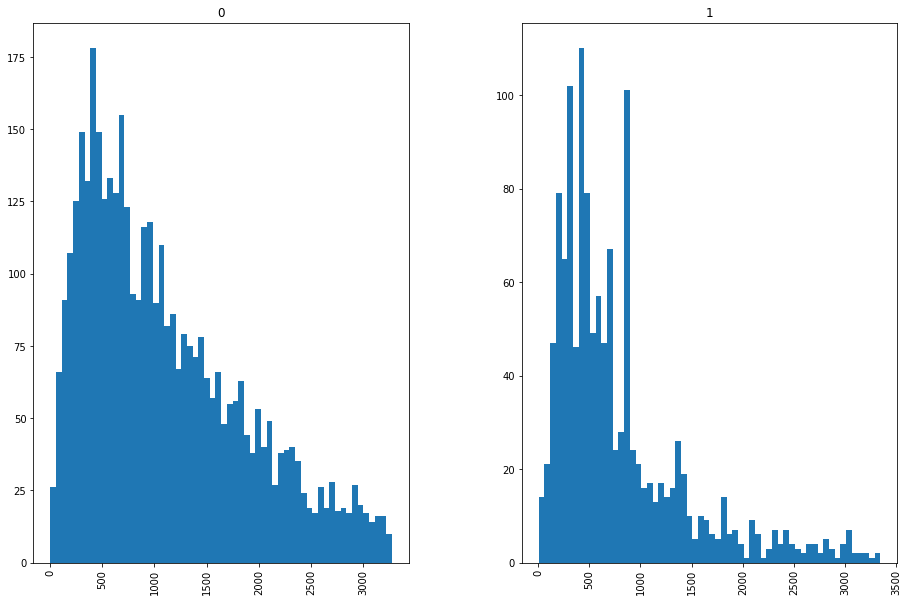

In [78]:
df.hist('length', by='spam', figsize=(15, 10), bins=60)

In [79]:
import string
from nltk.corpus import stopwords
def text_process(message):
    noPunc = [char for char in message if char not in string.punctuation]
    noPunc = ''.join(noPunc)
    
    return [word for word in noPunc.split() if word not in stopwords.words('english')]

In [80]:
df['text'] = df['text'].apply(text_process)

In [81]:
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [82]:
df['text'].head()

0    naturally irsistible corporate identity lt all...
1    stock trading gunslinger fanny merrill muzo co...
2    unbelievable new home made easy im wanting sho...
3    4 color printing special quest additional info...
4    money get softwa cd softwa compatibility gat g...
Name: text, dtype: object

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer().fit(df['text'])

In [84]:
print(len(bow_transformer.vocabulary_))

27730


In [85]:
message_bow = bow_transformer.transform(df['text'])

In [86]:

sparsity = (100.0 * message_bow.nnz/(message_bow.shape[0] * message_bow.shape[1]))
print('sparsity {}'.format(sparsity))

sparsity 0.2670247287577196


In [87]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer_bow = TfidfTransformer().fit(message_bow)

In [88]:
message_tfidf = tfidf_transformer_bow.transform(message_bow)

In [89]:

from sklearn.naive_bayes import MultinomialNB

def buildClassifier(alpha):
    text_classifier = MultinomialNB(alpha=alpha)
    return text_classifier

In [90]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.01))])

In [91]:

from sklearn.model_selection import GridSearchCV

In [92]:
parameters = {'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.8, 0.9, 1)}
grid_search = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='accuracy', cv=10, verbose=1)

In [93]:
grid_search.fit(df['text'], df['spam'])
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   38.6s finished


In [94]:
best_parameters

{'clf__alpha': 0.01}

In [95]:
best_accuracy


0.99008542348237

In [96]:
pipeline = Pipeline([('vec', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB(alpha=0.1))])

In [97]:
pipeline.fit(df['text'], df['spam'])

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))],
         verbose=False)

In [103]:
input_word = ['I love you']
input_word = text_process(input_word)
input_word = [' '.join(input_word)]
pipeline.predict(input_word)

array([1])

In [104]:
import pickle

In [105]:
filename = 'textClf.pkl'
pickle.dump(pipeline, open(filename, 'wb'))